<a href="https://colab.research.google.com/github/JohannFaust666/cats_dogs_cnn_classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow import keras


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout,Flatten, Activation
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

sns.set_style('whitegrid')

drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = '/content/kaggle'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# check if GPU works or not
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!kaggle competitions download -c dogs-vs-cats

In [ ]:
# unzip downloaded dataset
!unzip /content/dogs-vs-cats.zip

In [ ]:
# unzip test and train zips
!unzip /content/test1.zip
!unzip /content/train.zip

In [ ]:
path, dirs, files = next(os.walk('/content/train'))
file_count = len(files)
print(file_count)
base_dir = '/content/dogs_vs_cats_small'
os.mkdir(base_dir)

25000


In [ ]:
#make a new train/cv/test directories
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

valid_dir= os.path.join(base_dir, 'validation')
os.mkdir(valid_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

valid_cats_dir = os.path.join(valid_dir, 'cats')
os.mkdir(valid_cats_dir)

valid_dogs_dir = os.path.join(valid_dir, 'dogs')
os.mkdir(valid_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [ ]:
dir_path = '/content/train'

cat_count = 0
dog_count= 0
for i in os.listdir(dir_path):
    if i.startswith('cat.'):
        cat_count += 1
    elif i.startswith('dog.'):
        dog_count += 1

print(f"Cat images: {cat_count}")
print(f"Dog images: {dog_count}")

Cat images: 12500
Dog images: 12500


In [ ]:
original_dataset_dir = '/content/train'

# move 10,000 cat images from the original dataset to the train cat directory
fnames = ['cat.{}.jpg'.format(i) for i in range(10001)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_cats_dir, fname)
  shutil.copyfile(src, dst)

# move 1250 cat images from the original dataset to the validation cat directory
fnames = ['cat.{}.jpg'.format(i) for i in range(10001,11251)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(valid_cats_dir, fname)
  shutil.copyfile(src,dst)

# move 1250 cat images from the original dataset to the test cat directory
fnames = ['cat.{}.jpg'.format(i) for i in range(11251,12500)]
for fname in fnames:
  src= os.path.join(original_dataset_dir, fname)
  dst= os.path.join(test_cats_dir, fname)
  shutil.copyfile(src,dst)

# same for dog
fnames = ['dog.{}.jpg'.format(i) for i in range(10001)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_dogs_dir,fname)
  shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10001,11251)]
for fname in fnames:
  src = os.path.join(original_dataset_dir,fname)
  dst = os.path.join(valid_dogs_dir, fname)
  shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(11251,12500)]
for fname in fnames:
  src= os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir, fname)
  shutil.copyfile(src, dst)

In [ ]:
print(f'Total training cat images {len(os.listdir(train_cats_dir))}')
print(f'Total validation cat images {len(os.listdir(valid_cats_dir))}')
print(f'Total test cat images {len(os.listdir(test_cats_dir))}')
print('\n')
print(f'Total training dog images {len(os.listdir(train_dogs_dir))}')
print(f'Total validation cat images {len(os.listdir(valid_dogs_dir))}')
print(f'Total test cat images {len(os.listdir(test_dogs_dir))}')

Total training cat images 10001
Total validation cat images 1250
Total test cat images 1249


Total training dog images 10001
Total validation cat images 1250
Total test cat images 1249


In [ ]:
img_size = (128, 128)
batch_size = 32
img_shape = (img_size[0], img_size[1], 3)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_directory(train_dir, target_size = img_size, class_mode = 'binary',
                                       color_mode = 'rgb', shuffle = True, batch_size = batch_size)

valid_gen = ts_gen.flow_from_directory(valid_dir, target_size = img_size, class_mode = 'binary',
                                       color_mode = 'rgb', shuffle = True, batch_size = batch_size)

test_gen = ts_gen.flow_from_directory(test_dir, target_size = img_size, class_mode = 'binary',
                                       color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 20002 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


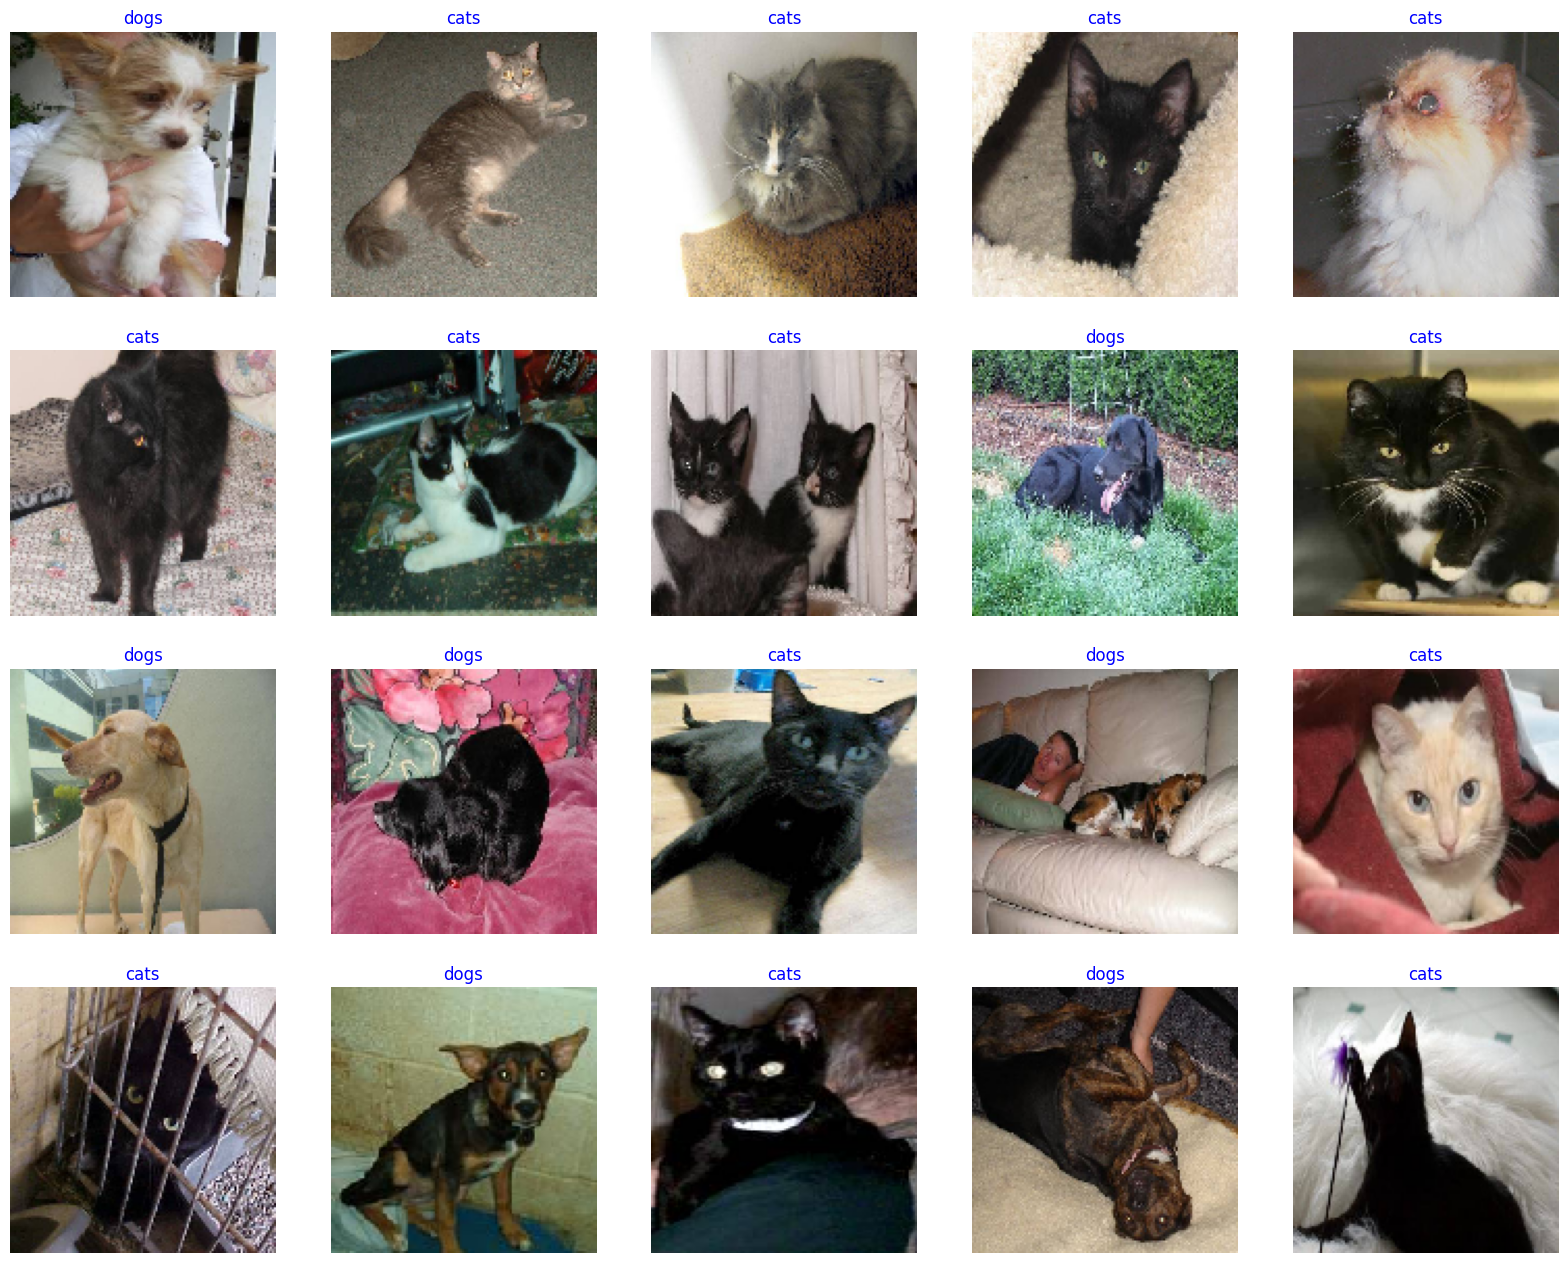

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(20, num_samples)):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = int(labels[i])
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [ ]:
img_shape = (img_size[0], img_size[1], 3)
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= 'imagenet', input_shape=img_shape, pooling= 'max')
base_model.trainable= False

num_classes = len(classes)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001),
    tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(l= 0.016), activity_regularizer = regularizers.l1(0.006), bias_regularizer= regularizers.l1(0.006), activation = 'relu'),
    tf.keras.layers.Dropout(rate = 0.4, seed = 40),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Выходные данные были обрезаны до нескольких последних строк (5000).
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessTruncatedNormalV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in dev

In [ ]:
history = model.fit(x= train_gen, validation_data= valid_gen, epochs= 10, verbose = 1, validation_steps = None, shuffle = False)

Выходные данные были обрезаны до нескольких последних строк (5000).
Executing op __inference_train_function_51142 in device /job:localhost/replica:0/task:0/device:GPU:0
490/626 [======================>.......] - ETA: 15s - loss: 0.3832 - accuracy: 0.9306Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_51142 in device /job:localhost/replica:0/task:0/device:GPU:0
491/626 [======================>.......] - ETA: 15s - loss: 0.3831 - accuracy: 0.9308Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_51142 in device /job:localhost/replica:0/task:0/device:GPU:0
492/626 [======================>.......] - ETA: 14s - loss: 0.3829 - accuracy: 0.9309Executing op ReadVariableOp in device /job:localhost/r

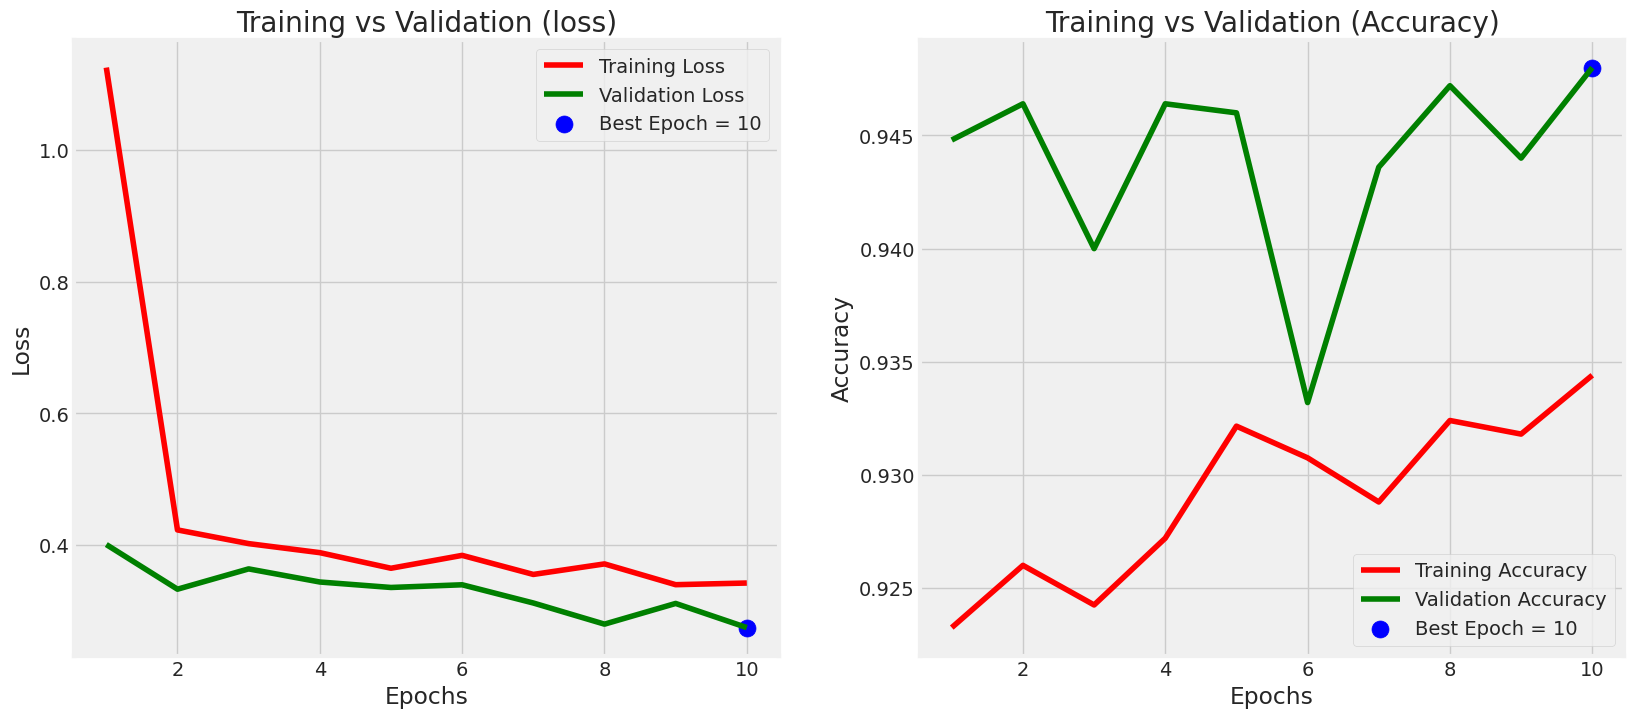

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs, train_loss, 'r', label = 'Training Loss')
plt.plot(Epochs, val_loss, 'g', label = 'Validation Loss')
plt.scatter(index_loss +1, val_lowest, s = 150, c = 'blue', label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs, train_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label = 'Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s= 150, c = 'blue', label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_gen, steps= 32, verbose = 1)
val_score = model.evaluate(valid_gen, steps = 32, verbose = 1)
test_score = model.evaluate(test_gen, steps = 32, verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identi

In [ ]:
# Make predictions on the test set
preds = model.predict(test_gen)

# Convert the predictions to binary classes (0 or 1)
predicted_classes = (preds > 0.5).astype(int)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariable

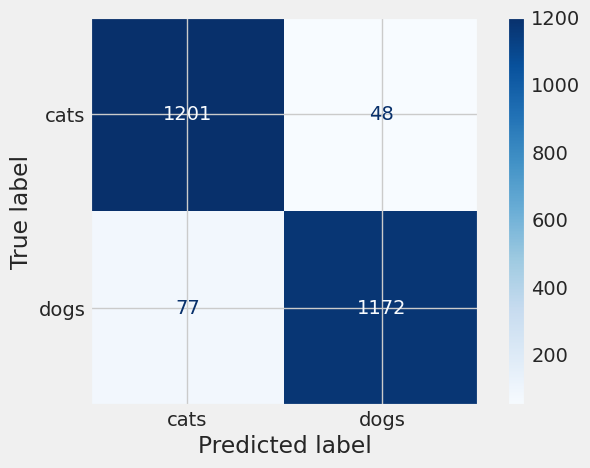

In [ ]:
# Get the true labels from the generator
true_classes = test_gen.classes

# Calculate the confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=test_gen.class_indices)
disp.plot(cmap='Blues', values_format='d')

In [ ]:
classification_rep = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices)
print("\nClassification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

        cats       0.94      0.96      0.95      1249
        dogs       0.96      0.94      0.95      1249

    accuracy                           0.95      2498
   macro avg       0.95      0.95      0.95      2498
weighted avg       0.95      0.95      0.95      2498

